In [1]:
from scipy.optimize import nnls
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
import torch
from sklearn.decomposition import NMF

from random import sample

from functions import cosine_HA
from AAUtoSig_init import AAUtoSig, train_AAUtoSig
from optuna_opt import optuna_tune

## Data management
Load the frequency matrix generated by the tool SomaticSiMu, and the set of signatures used for generating each instance. These are then matches by the patient ID, to determine what signatures are present in a given sub-sample

In [2]:
m = pd.read_csv(r'Q:\AUH-HAEM-FORSK-MutSigDLBCL222\article_1\generated_data\SomaticSiMu\Lung-SCC_SBS96.csv')#.drop(['Unnamed: 0'], axis=1)

In [3]:
groundtruth = [line.strip("\n") for line in open(r'Q:\AUH-HAEM-FORSK-MutSigDLBCL222\article_1\generated_data\SomaticSiMu\Lung-SCC_sbs_sigs.txt')]
groundtruth = pd.DataFrame([ast.literal_eval(x) for x in groundtruth])
groundtruth[0] = groundtruth[0].astype(int)


sig_names = np.unique(groundtruth.drop([0], axis = 1).fillna(":("))[1::]
COSMIC = pd.read_csv(r'COSMIC\COSMIC_v3.2_SBS_GRCh37.txt', sep = '\t', index_col=0)
sigs = COSMIC[sig_names]

In [4]:
xd = groundtruth[0].sort_values().tolist()
for i in range(len(xd)-1):
    if not (xd[i] + 1 == xd[i + 1]):
        print(xd[i])


26
40
42
58
120
152
154
167
187
199
218
234
247
249
252
268
517
548
580
611
642
674
705


## Split data
Firstly we write a method to split the mutational profile matrix into a training and validation set.

In [5]:
def split_data(data, frac_1):
  x_train = data.sample(frac = frac_1)
  x_validation = data.drop(x_train.index)
  return x_train, x_validation

# NMF performance

In [6]:
def out_errorNMF(train_df, validation_df, nsigs, true_sigs, max = False):
  model = NMF(n_components=nsigs, init='random', max_iter = 1000)
  exposures = model.fit_transform(train_df)
  signatures = model.components_
  cos_NMF = cosine_HA(signatures, true_sigs.to_numpy().T)[0]
  cos_mean = np.mean(cos_NMF.diagonal())
  #cos_max = cosine_max(signatures, true_sigs.to_numpy().T)


  ref_exposures = model.transform(X = validation_df)
  rec = np.dot(ref_exposures, signatures)
  MSE = np.mean(((validation_df - rec)**2).to_numpy())
  
  return cos_mean, MSE

# AAUtoSig performance

In [7]:
def out_error_AAUtoSig(train_df, validation_df, nsigs,true_sigs, max = False):
    model = AAUtoSig(nsigs)

    # Validation using MSE Loss function
    loss = torch.nn.MSELoss(reduction='mean')
    #params = optuna_tune(train_df, nsigs, model_name = "AAUtoSig")

     # Using an Adam Optimizer with lr = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)#params['lr1'])
    train_AAUtoSig(1000, model, train_df, loss_function= loss, optimizer=optimizer, batch_size = 32)#params['batch_size'])

    signatures = model.dec1.weight.data    
    signatures = pd.DataFrame(signatures.numpy())
    validation_tensor = torch.tensor(validation_df.values, 
                             dtype = torch.float32)
    rec_data = model(validation_tensor)

    MSE = np.mean(((validation_df - rec_data.detach().numpy())**2).to_numpy())
    #return(MSE)
    Y = cosine_HA(signatures.T, true_sigs.T)
    cos_mean = np.mean(Y[0].diagonal())

    return cos_mean, MSE

## Performance analysis

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


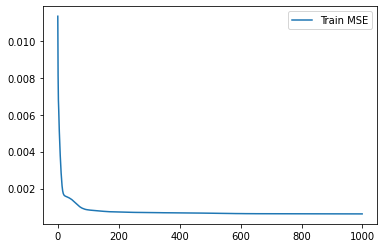

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


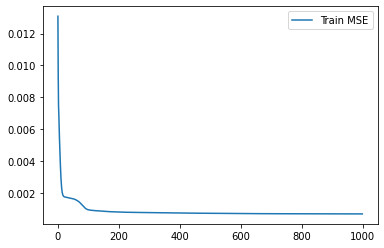

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


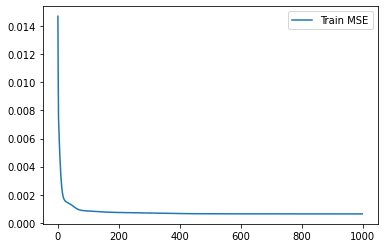

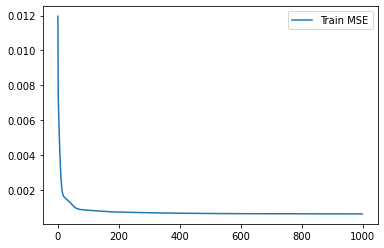

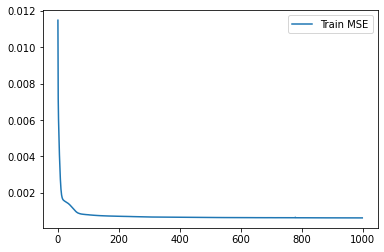

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


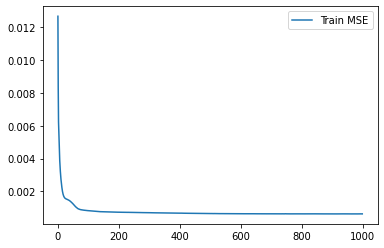

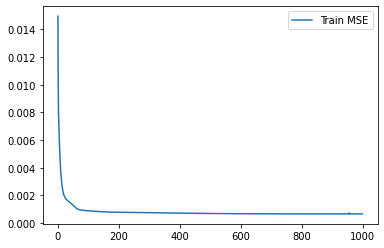

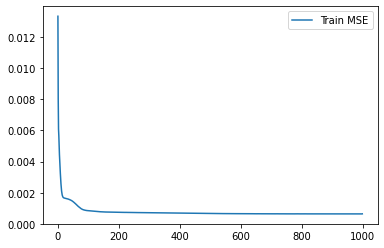

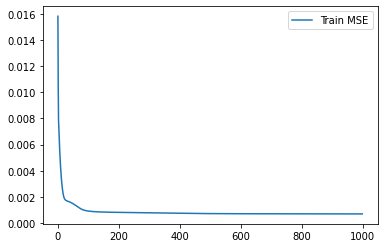

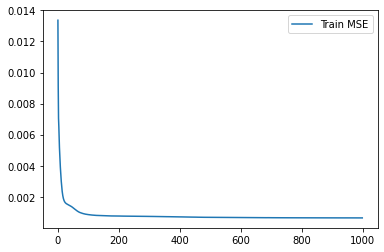

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


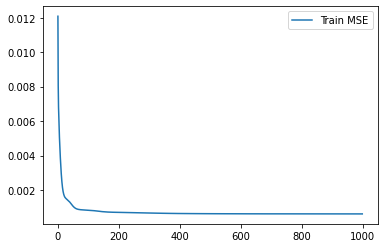

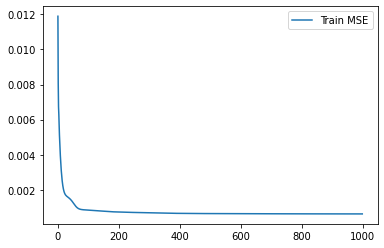

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


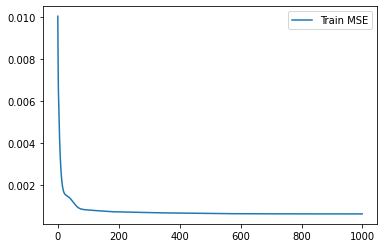

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


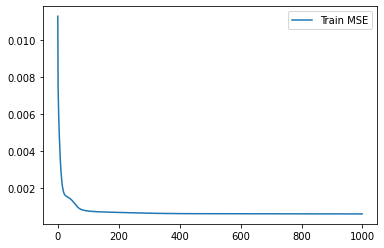

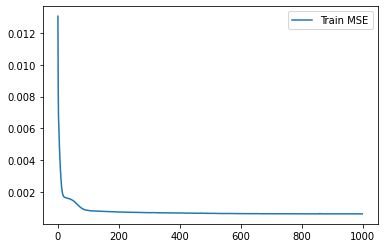

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


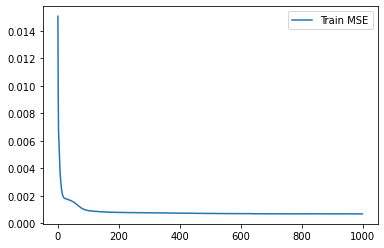

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


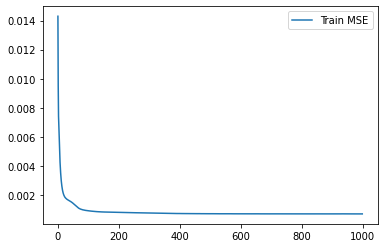

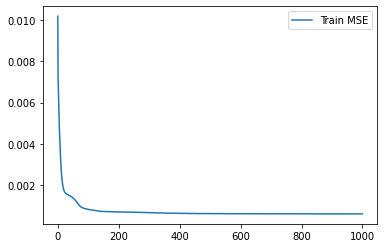

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


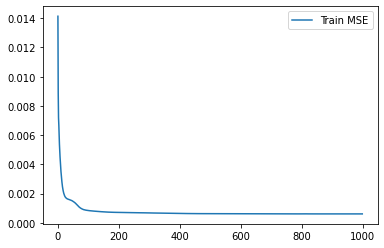

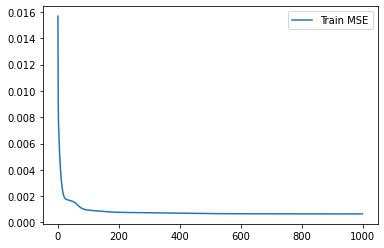

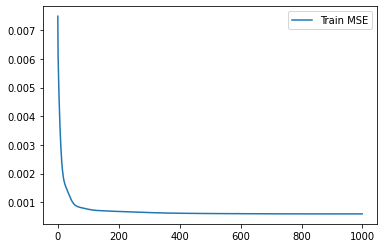

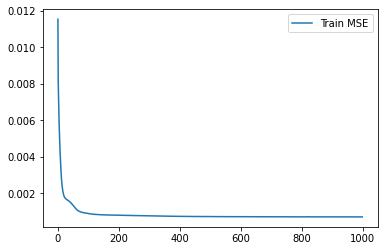

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


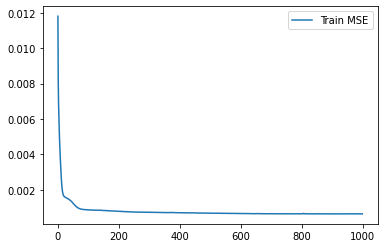

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


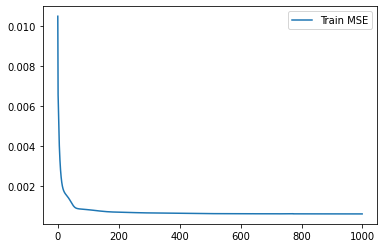

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


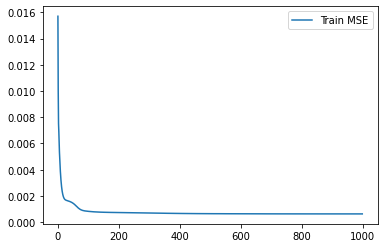

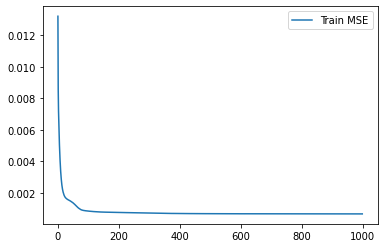

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


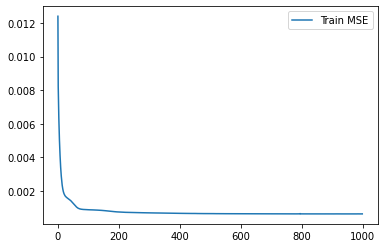

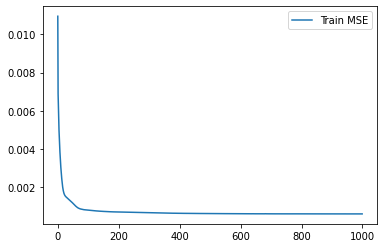

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


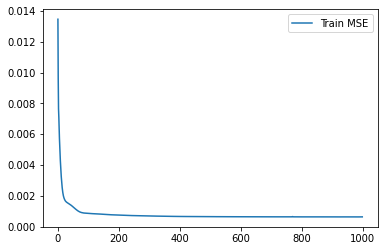

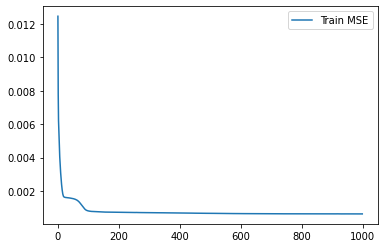

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


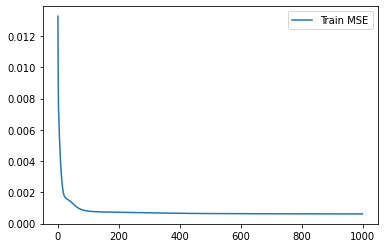

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


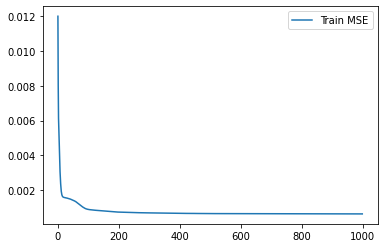

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


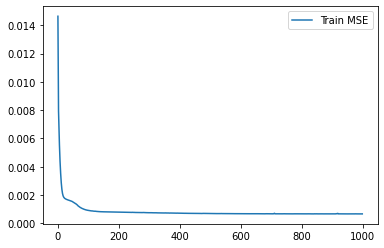

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


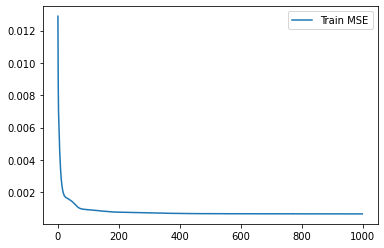

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


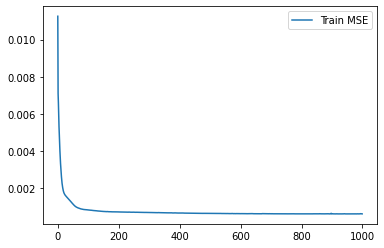

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


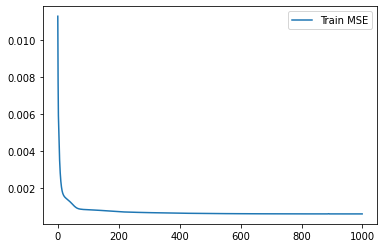

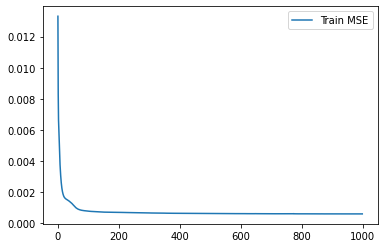

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


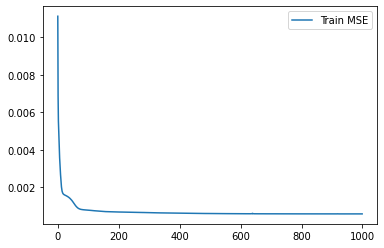

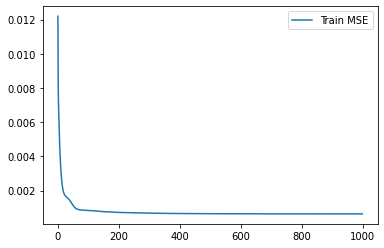

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


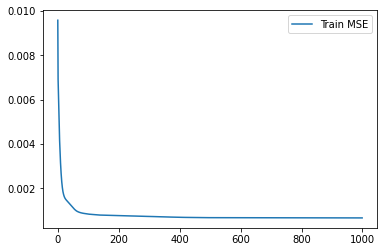

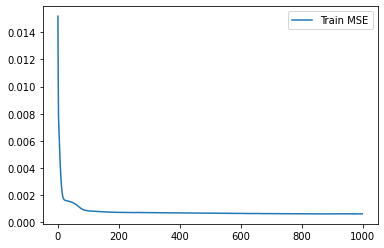

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


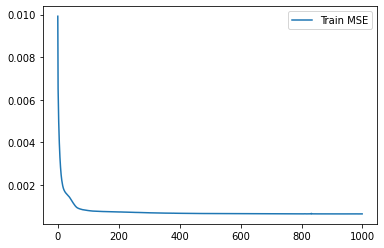

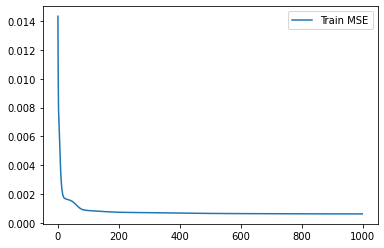

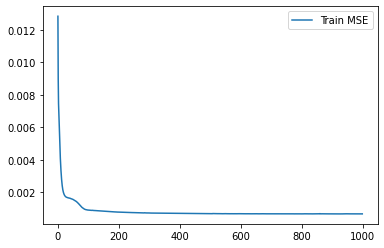

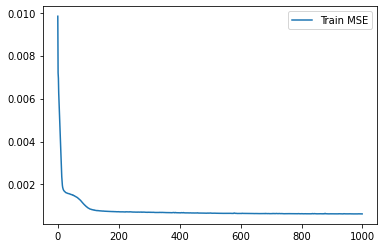

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


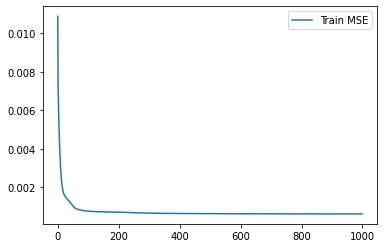

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


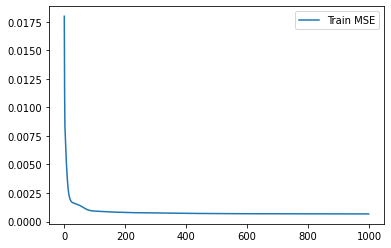

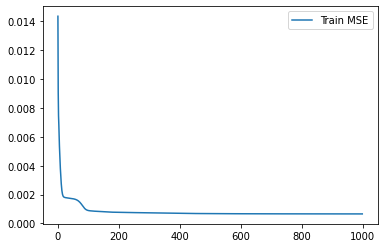

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


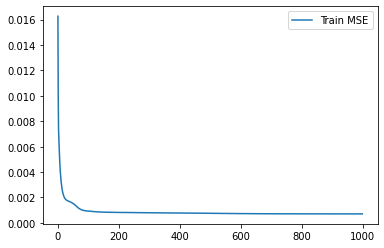

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


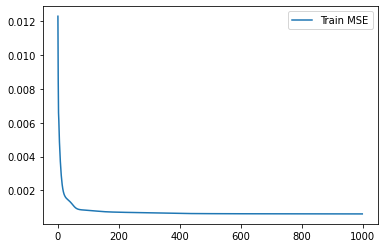

In [8]:
def performance_analysis(m, m_sigs):
  m = m.sort_values('0')
  mut_matrix = (m.drop(['Unnamed: 0', '0'], axis = 1)).T.sample(400)
  train_data, test_data = split_data(mut_matrix, 0.75)
  
  idx_train = train_data.index
  idx_test = test_data.index
  y = [str(x) for x in m_sigs[0]]

  train_idx = list (set(idx_train) & set(y))
  test_idx = list(set(idx_test) & set(y))
  train_data = train_data[train_data.index.isin(train_idx)]/train_data.max().max()
  test_data = test_data[test_data.index.isin(test_idx)]/train_data.max().max()

  m_sigs_train = m_sigs[m_sigs[0].isin([int(x) for x in train_idx])]
  m_sigs_test = m_sigs[m_sigs[0].isin([int(x) for x in test_idx])]
  sig_names_train = np.unique(m_sigs_train.drop([0], axis = 1).fillna(":("))[1::]
  sig_names_test = np.unique(m_sigs_test.drop([0], axis = 1).fillna(":("))[1::]

  COSMIC = pd.read_csv(r'COSMIC\COSMIC_v3.1_SBS_GRCh38.txt', sep = '\t', index_col=0)
  #Arrange COSMIC to be the same ordering as count data
  COSMIC = COSMIC.sort_index()
  
  #print(m['0'].to_list()==COSMIC.index)
  sigs_train = COSMIC[sig_names_train]
  nsigs = len(sig_names_train)
  return( out_errorNMF(train_data, test_data, nsigs, sigs_train) + 
          out_error_AAUtoSig(train_data, test_data, nsigs, sigs_train))

asd = [performance_analysis(m, groundtruth) for _ in range(50)] 
result = pd.DataFrame(asd)
result.columns = ["NMF_perm", "outNMF", "AE_perm", "outAE" ]


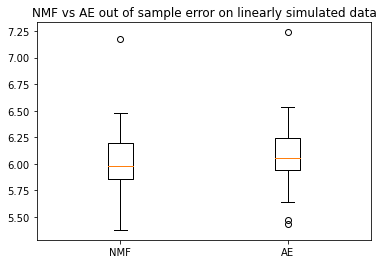

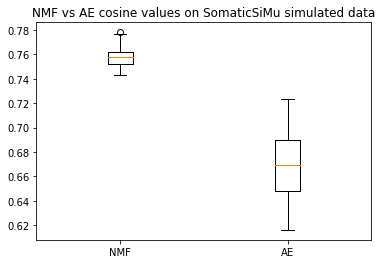

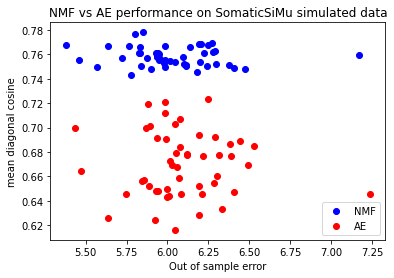

In [9]:
plt.boxplot(result[['outNMF', 'outAE']], labels = ["NMF", "AE"])
plt.title('NMF vs AE out of sample error on linearly simulated data')
plt.show()

plt.boxplot(result[['NMF_perm', 'AE_perm']] ,labels = ["NMF", "AE"])
plt.title('NMF vs AE cosine values on SomaticSiMu simulated data')
plt.show()

plt.scatter(y = result['NMF_perm'], x = result['outNMF'], c = 'blue', label = 'NMF')
plt.scatter(y = result['AE_perm'], x = result['outAE'], c = 'red', label = 'AE')
plt.xlabel('Out of sample error')
plt.ylabel('mean diagonal cosine')
plt.title('NMF vs AE performance on SomaticSiMu simulated data')
plt.legend()
plt.show()
#plt.savefig('linear.png', transparent=True)